# Modelos de predicción de actividad semanal en X

Predice el número de tweets de la semana **t** usando las **4 semanas anteriores** (t-1, t-2, t-3, t-4) como features.

| Modelo | Tipo |
|--------|------|
| Regresión Lineal | Lineal |
| Random Forest | Machine Learning |
| Red Neuronal Mínima | Deep Learning (TensorFlow) |

Métrica: **RMSE** (Root Mean Squared Error) en escala original (nº de tweets).


In [1]:
# Entorno (Google Colab)
import subprocess, os

if not os.path.isdir('AP'):
    subprocess.run(['git', 'clone', 'https://github.com/0xnito/AP.git'], check=True)
%cd AP

!pip install -q kaggle

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado

In [1]:
# Descarga del dataset
import os

os.makedirs('data/raw', exist_ok=True)
csv_path = 'data/raw/all_musk_posts.csv'

if os.path.exists(csv_path):
    print('Dataset ya disponible.')
else:
    kaggle_path = '/root/.kaggle/kaggle.json'
    if not os.path.exists(kaggle_path):
        print(
            'Descarga manual necesaria:\n'
            'https://www.kaggle.com/datasets/dadalyndell/elon-musk-tweets-2010-to-2025-march\n'
            'Coloca all_musk_posts.csv en data/raw/'
        )
    else:
        !kaggle datasets download -d dadalyndell/elon-musk-tweets-2010-to-2025-march -p data/raw
        !unzip -o data/raw/elon-musk-tweets-2010-to-2025-march.zip -d data/raw
        print('Dataset descargado.')

Dataset ya disponible.


In [2]:
# Carga y agregación semanal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

df = pd.read_csv('data/raw/all_musk_posts.csv')
df['createdAt'] = pd.to_datetime(df['createdAt'])
df['createdAt_naive'] = df['createdAt'].dt.tz_localize(None)
df['week'] = df['createdAt_naive'].dt.to_period('W').apply(lambda r: r.start_time)

weekly_counts = (
    df.groupby('week')
      .size()
      .reset_index(name='tweet_count')
)

print(f'Número de semanas: {len(weekly_counts)}')
weekly_counts.head()

C:\Users\corre\AppData\Local\Temp\ipykernel_8480\2773268432.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\corre\AppData\Local\Temp\ipykernel_8480\2773268432.py:7: DtypeWarning: Columns (11,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/raw/all_musk_posts.csv')


Número de semanas: 680


,week,tweet_count
0,2010-05-31,1
1,2011-11-28,5
2,2011-12-19,13
3,2011-12-26,31
4,2012-01-02,6


In [3]:
# Construcción de features con 4 lags
N_LAGS = 4

counts = weekly_counts['tweet_count'].values.astype(float)

X_all = np.array([counts[i - N_LAGS:i] for i in range(N_LAGS, len(counts))])
y_all = counts[N_LAGS:]

print(f'Muestras totales : {len(X_all)}')
print(f'Shape X          : {X_all.shape}')   # (n_samples, 4)
print(f'Shape y          : {y_all.shape}')

Muestras totales : 676
Shape X          : (676, 4)
Shape y          : (676,)


In [4]:
# División temporal 70 / 15 / 15
n       = len(X_all)
n_train = int(n * 0.70)
n_val   = int(n * 0.15)

X_train, y_train = X_all[:n_train],               y_all[:n_train]
X_val,   y_val   = X_all[n_train:n_train+n_val],  y_all[n_train:n_train+n_val]
X_test,  y_test  = X_all[n_train+n_val:],         y_all[n_train+n_val:]

print(f'Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}')

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Train: 473 | Val: 101 | Test: 102


---
## 1. Modelo Lineal

In [5]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

rmse_lr_train = rmse(y_train, lr.predict(X_train))
rmse_lr_val   = rmse(y_val,   lr.predict(X_val))
rmse_lr_test  = rmse(y_test,  lr.predict(X_test))

print('Regresión Lineal')
print(f'  RMSE Train      : {rmse_lr_train:.2f}')
print(f'  RMSE Validación : {rmse_lr_val:.2f}')
print(f'  RMSE Test       : {rmse_lr_test:.2f}')

Regresión Lineal
  RMSE Train      : 19.28
  RMSE Validación : 44.10
  RMSE Test       : 104.73


---
## 2. Modelo de Machine Learning — Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

rmse_rf_train = rmse(y_train, rf.predict(X_train))
rmse_rf_val   = rmse(y_val,   rf.predict(X_val))
rmse_rf_test  = rmse(y_test,  rf.predict(X_test))

# Número parámetros: suma de nodos en todos los árboles
n_params_rf = sum(t.tree_.node_count for t in rf.estimators_)

print('Random Forest')
print(f'  RMSE Train      : {rmse_rf_train:.2f}')
print(f'  RMSE Validación : {rmse_rf_val:.2f}')
print(f'  RMSE Test       : {rmse_rf_test:.2f}')
print(f'  Nodos totales   : {n_params_rf}')

Random Forest
  RMSE Train      : 14.31
  RMSE Validación : 69.55
  RMSE Test       : 245.41
  Nodos totales   : 5596


---
## 3. Red Neuronal  


In [7]:
import tensorflow as tf
from tensorflow import keras


def build_model(n_lags: int = 4, hidden_size: int = 4) -> keras.Model:

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(n_lags,)))
    model.add(keras.layers.Dense(hidden_size, activation="relu", name="hidden"))
    model.add(keras.layers.Dense(1, activation="linear", name="output"))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.01),
        loss="mse",
        metrics=["mae"],
    )

    return model


def count_parameters(model: keras.Model) -> int:
    return int(model.count_params())

In [9]:
# Normalización (media/std del train)
mu    = X_train.mean()
sigma = X_train.std()

X_train_n = (X_train - mu) / sigma
X_val_n   = (X_val   - mu) / sigma
X_test_n  = (X_test  - mu) / sigma

y_train_n = (y_train - mu) / sigma
y_val_n   = (y_val   - mu) / sigma

#  Construir modelo
tf.random.set_seed(42)
model = build_model(n_lags=N_LAGS, hidden_size=4)
model.summary()
print(f'\nParámetros totales: {count_parameters(model)}')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)


Parámetros totales: 25


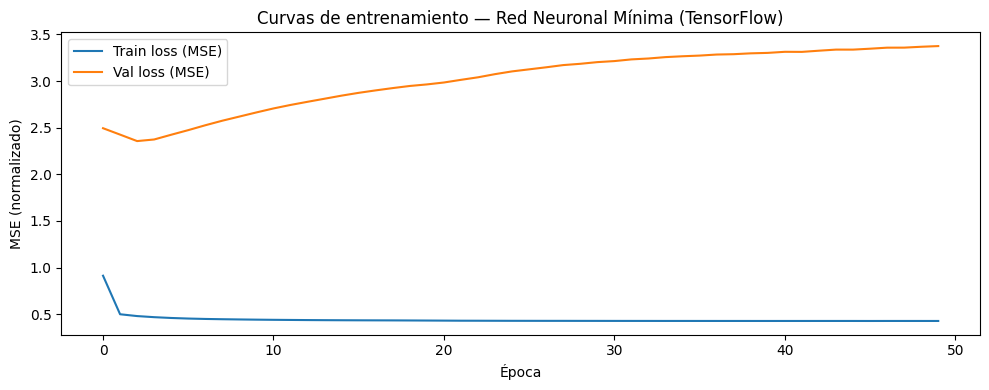

Loss final → Train: 0.4274 | Val: 3.3757


In [10]:
# ── Entrenamiento ─────────────────────────────────────────────────────────────
history = model.fit(
    X_train_n, y_train_n,
    validation_data=(X_val_n, y_val_n),
    epochs=50,
    batch_size=16,
    verbose=0,
)

# ── Curvas de entrenamiento ───────────────────────────────────────────────────
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'],     label='Train loss (MSE)')
plt.plot(history.history['val_loss'], label='Val loss (MSE)')
plt.xlabel('Época')
plt.ylabel('MSE (normalizado)')

plt.title('Curvas de entrenamiento — Red Neuronal Mínima (TensorFlow)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Loss final → Train: {history.history['loss'][-1]:.4f} | Val: {history.history['val_loss'][-1]:.4f}")

In [11]:
# ── Evaluación en escala original ─────────────────────────────────────────────
def predict_rmse_nn(X_norm, y_orig):
    pred_norm = model.predict(X_norm, verbose=0).flatten()
    pred = pred_norm * sigma + mu
    return rmse(y_orig, pred)

rmse_nn_train = predict_rmse_nn(X_train_n, y_train)
rmse_nn_val   = predict_rmse_nn(X_val_n,   y_val)
rmse_nn_test  = predict_rmse_nn(X_test_n,  y_test)
n_params_nn   = count_parameters(model)

print('Red Neuronal Mínima (TensorFlow)')
print(f'  RMSE Train      : {rmse_nn_train:.2f}')
print(f'  RMSE Validación : {rmse_nn_val:.2f}')
print(f'  RMSE Test       : {rmse_nn_test:.2f}')
print(f'  Nº parámetros   : {n_params_nn}')

Red Neuronal Mínima (TensorFlow)
  RMSE Train      : 18.85
  RMSE Validación : 53.49
  RMSE Test       : 146.90
  Nº parámetros   : 25


---
## Resumen de resultados

In [12]:
results = pd.DataFrame({
    'Modelo':        ['Regresión Lineal', 'Random Forest', 'Red Neuronal Mínima'],
    'RMSE Train':    [round(rmse_lr_train, 2), round(rmse_rf_train, 2), round(rmse_nn_train, 2)],
    'RMSE Val':      [round(rmse_lr_val,   2), round(rmse_rf_val,   2), round(rmse_nn_val,   2)],
    'RMSE Test':     [round(rmse_lr_test,  2), round(rmse_rf_test,  2), round(rmse_nn_test,  2)],
    'Nº Parámetros': ['-', n_params_rf, n_params_nn],
})

print(results.to_markdown(index=False))
results

| Modelo              |   RMSE Train |   RMSE Val |   RMSE Test | Nº Parámetros   |
|:--------------------|-------------:|-----------:|------------:|:----------------|
| Regresión Lineal    |        19.28 |      44.1  |      104.73 | -               |
| Random Forest       |        14.31 |      69.55 |      245.41 | 5596            |
| Red Neuronal Mínima |        18.85 |      53.49 |      146.9  | 25              |


,Modelo,RMSE Train,RMSE Val,RMSE Test,Nº Parámetros
0,Regresión Lineal,19.28,44.10,104.73,-
1,Random Forest,14.31,69.55,245.41,5596
2,Red Neuronal Mínima,18.85,53.49,146.90,25
